# Practice 7. part2 - CCD noise

## Problem 2

1. Open all files from CCD folders (there are background noise data recorded at different temperatures), plot them.
2. Calculate average and RMS.
3. Plot dependences of average and RMS from temperature. Can you offer a function to fit data?

Hint: use a results from the previus practice.

#### Info

The noise of optical detectors (including CCDs) depends on temperature. Usually noise increases with increasing temperature, so receivers are often cooled.
The CCD in the example is usually cooled down to -70C.
The matrix itself has a size of 1024$\times$128 elements, but averaging "by columns" gives an one-dimensional array of 1024$\times$1.

This is a background noise measurement, not a spectral one, and we do not need to use wavelength. Use the numbers of the matrix elements only (corresponding to the line number in the file).

Previous results:

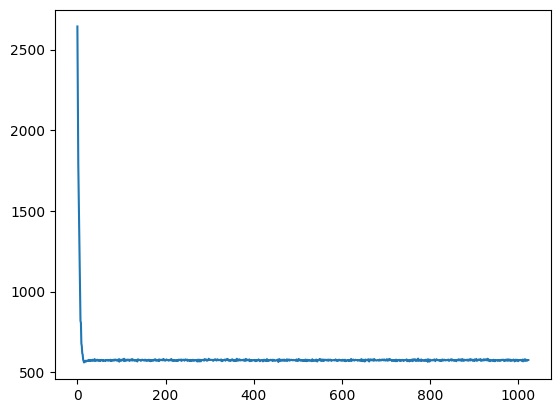

In [30]:
path = './practice_6_data/ascii_vs_binary/'
filename_bin = '-60 30 sec.dat'
filename_txt = 'ccd -60C.asc'


txt_data = np.loadtxt(path + filename_txt)

plt.plot(txt_data[: , 1])
plt.show()

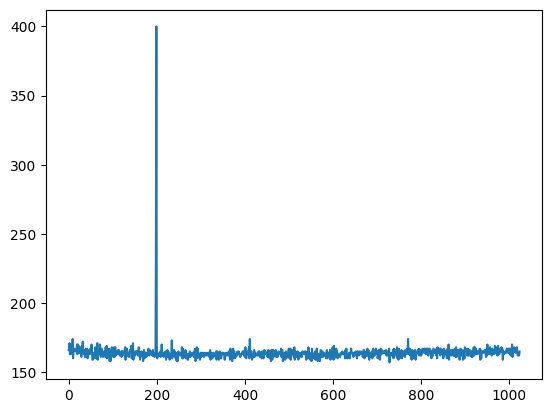

In [41]:
with open(path + filename_bin, 'rb') as file:
    raw_str = file.read()

#print(raw_str)

spectrum = []

for i in range(len(raw_str)//2):
    dbyte = raw_str[i*2 : i*2 + 2]
    int1 = int.from_bytes(dbyte, 'little') 
    spectrum.append(int1)

plt.plot(spectrum)
plt.show()

Lets analyse dependence of noise from temperature.

Files in the folder (and images):

D:\programming\practices\practice_7_data\ccd_bin

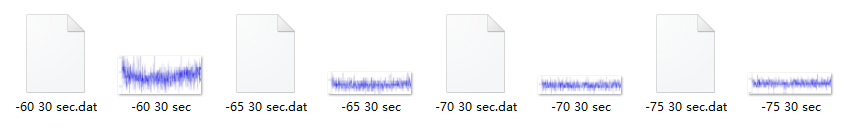

Let's get names of the files:

In [72]:
import os
import matplotlib.pyplot as plt
import numpy as np



path = './practice_7_data/ccd_bin/'
#path = './practice_7_data/ccd_bin_1sec/'

filelist = [f for f in os.listdir(path) if os.path.isfile(path + f)]
# filelist = os.listdir(path) # if you need a folders also or there is no any folder
print(filelist)

['-60 30 sec.dat', '-60 30 sec.gif', '-65 30 sec.dat', '-65 30 sec.gif', '-70 30 sec.dat', '-70 30 sec.gif', '-75 30 sec.dat', '-75 30 sec.gif']


Now let's plot noise for each temperature and calculate average

-60 30 sec.dat 163.9462890625
-65 30 sec.dat 153.505859375
-70 30 sec.dat 149.935546875
-75 30 sec.dat 148.5107421875


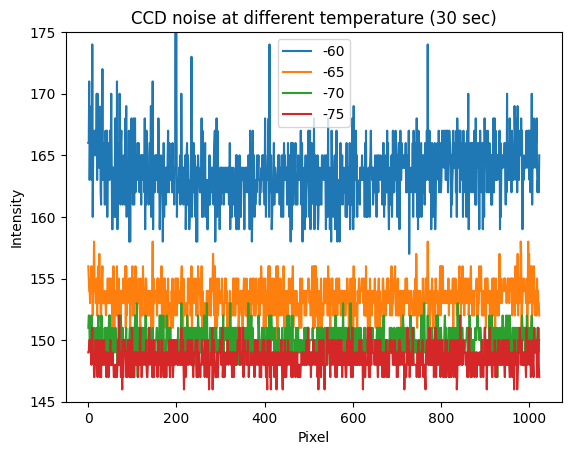

In [74]:
averages = []
temperatures = []
lst = []
for name in filelist:
    if name.split('.')[1] != 'dat':
        continue# 

    with open(path + name, 'rb') as file:
        raw_str = file.read()
    
    spectrum = []
    for i in range(len(raw_str)//2):
        dbyte = raw_str[i*2 : i*2 + 2]
        int1 = int.from_bytes(dbyte, 'little') 
        spectrum.append(int1)

    spectrum = np.array(spectrum)

    lst.append(spectrum)
    #name=name.replace('30 sec.dat' , '')
    n = name.split(' ' )[0]
    temperatures.append(int(n))
    plt.plot(spectrum, label=n)

    avr = np.average(spectrum)
    averages.append(avr)
    print(name, avr)
    
        
plt.title("CCD noise at different temperature (30 sec)")
plt.xlabel("Pixel")
plt.legend()
plt.ylabel("Intensity")
plt.ylim(145, 175)
plt.show()

Let's try to fit the data by square function using numpy:

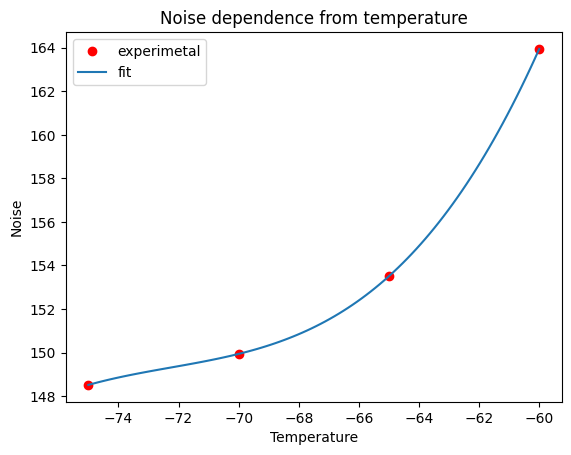

In [75]:
plt.plot(temperatures, averages, 'ro', label='experimetal')

x = np.linspace(temperatures[0], temperatures[-1], 100)
param = np.polyfit(temperatures, averages, 3) # returns an array of coefficients of a polynomial of degree 2
plt.plot(x, np.polyval(param, x), label='fit')

plt.legend()
plt.title("Noise dependence from temperature")
plt.xlabel("Temperature")
plt.ylabel("Noise")
plt.show()

The fiting quite good, by the real functional dependence is exponential.

Let's fit by exponential function $a+be^{t/\tau}$

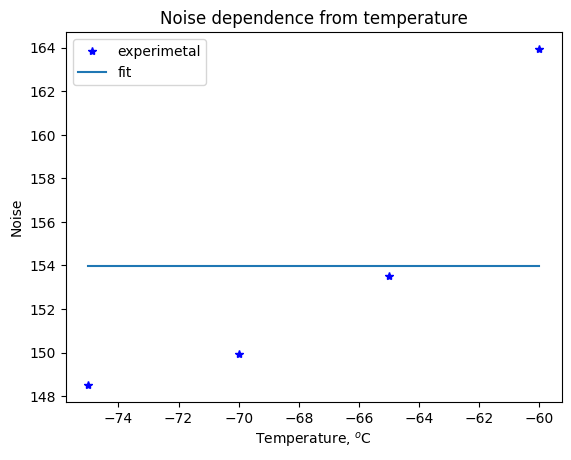

In [76]:
from scipy.optimize import curve_fit
'''
def exp(t, a, k):
    return a*np.exp(k * x)
'''

def exp(t, a, b, tau):
    return a + b*np.exp(t/tau)

plt.plot(temperatures, averages, 'b*', label='experimetal')

x_ticks = np.linspace(temperatures[0], temperatures[-1], 100)

k_exp = curve_fit(exp, temperatures, averages)[0]
#m_lin = curve_fit(lin, x, np.log(y))[0]
y_appr = exp(x_ticks, *k_exp)


#param = np.polyfit(temperatures, averages, 2) # returns an array of coefficients of a polynomial of degree 2
plt.plot(x_ticks, y_appr, label='fit')

plt.legend()
plt.title("Noise dependence from temperature")
plt.xlabel("Temperature, $^o$C")
plt.ylabel("Noise")
plt.show()

To improve the fitting we must specify fitting parameters using optional parameter p0, which is a list of initial parameters.

We can see that parameter a is about 150 (an average level at low temperature), exponent parameter is about 10 (because the noise increase  in three times for approx. 10 degrees), and recalculate temperature to K (or introduce a 273 degrees shift)

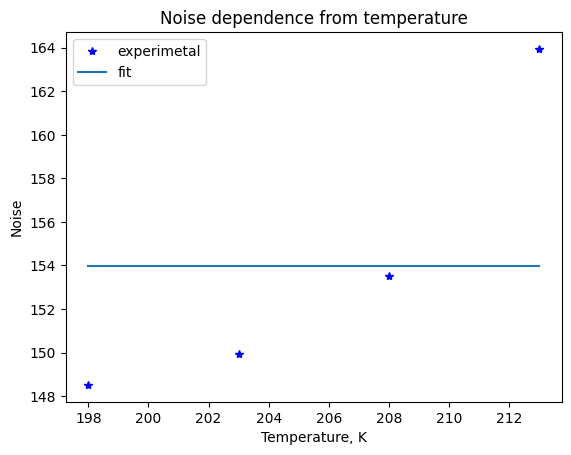

In [80]:
from scipy.optimize import curve_fit
'''
def exp(x, a, k):
    return a*np.exp(k * x)
'''

def exp(t, a, b, tau):
    return a + b*np.exp(t/tau)


t_k = np.array(temperatures) + 273

plt.plot(t_k, averages, 'b*', label='experimetal')

x_ticks = np.linspace(t_k[0], t_k[-1], 100)

p = [145, 1e-10, 10]
#p = [145, 1e-10, 10]
k_exp = curve_fit(exp, t_k, averages, p0=p)[0]
#m_lin = curve_fit(lin, x, np.log(y))[0]
y_appr = exp(x_ticks, *k_exp)


#param = np.polyfit(temperatures, averages, 2) # returns an array of coefficients of a polynomial of degree 2
plt.plot(x_ticks, y_appr, label='fit')

plt.legend()
plt.title("Noise dependence from temperature")
plt.xlabel("Temperature, K")
plt.ylabel("Noise")
plt.show()

What are the fitting parameters?

In [81]:
print(k_exp)

[ 1.53974610e+02 -2.15779224e-07 -1.03381406e+03]


Let's plot the exponential function to find parameters

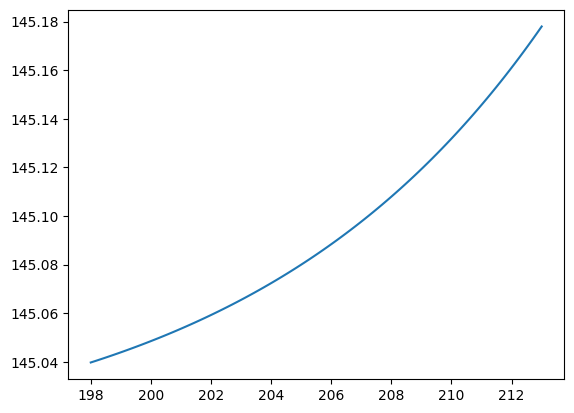

In [58]:
def exp(t, a, b, k):
    return a + b*np.exp(k*t)

x_ticks = np.linspace(t_k[0], t_k[-1], 100)
p = [145, 1e-10, 0.1]

y = exp(x_ticks, *p)
plt.plot(x_ticks, y)
plt.show()

But if you replace input data to ccd_bin_1sec - you'll get excelent fit:

['-20 1 сек.dat', '-30 1 sec.dat', '-40 1 sec.dat', '-50 1 sec.dat', '-55 1 sec.dat', '-60 1 sec.dat', '-65 1 sec.dat', '-70 1 sec.dat', '-75 1 sec.dat']
-20 1 сек.dat 296.435546875
-30 1 sec.dat 186.662109375
-40 1 sec.dat 155.306640625
-50 1 sec.dat 149.646484375
-55 1 sec.dat 148.8974609375
-60 1 sec.dat 148.5576171875
-65 1 sec.dat 148.3349609375
-70 1 sec.dat 148.40234375
-75 1 sec.dat 147.939453125


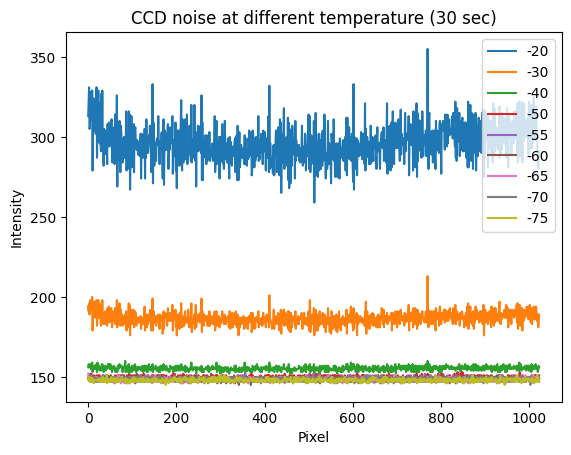

In [86]:
import os
import matplotlib.pyplot as plt
import numpy as np



#path = './practice_7_data/ccd_bin/'
path = './practice_7_data/ccd_bin_1sec/'

filelist = [f for f in os.listdir(path) if os.path.isfile(path + f)]
# filelist = os.listdir(path) # if you need a folders also or there is no any folder
print(filelist)

averages = []
temperatures = []
lst = []
for name in filelist:
    if name.split('.')[1] != 'dat':
        continue# 

    with open(path + name, 'rb') as file:
        raw_str = file.read()
    
    spectrum = []
    for i in range(len(raw_str)//2):
        dbyte = raw_str[i*2 : i*2 + 2]
        int1 = int.from_bytes(dbyte, 'little') 
        spectrum.append(int1)

    spectrum = np.array(spectrum)

    lst.append(spectrum)
    #name=name.replace('30 sec.dat' , '')
    n = name.split(' ' )[0]
    temperatures.append(int(n))
    plt.plot(spectrum, label=n)

    avr = np.average(spectrum)
    averages.append(avr)
    print(name, avr)
    
        
plt.title("CCD noise at different temperature (30 sec)")
plt.xlabel("Pixel")
plt.legend()
plt.ylabel("Intensity")
#plt.ylim(145, 175)
plt.show()

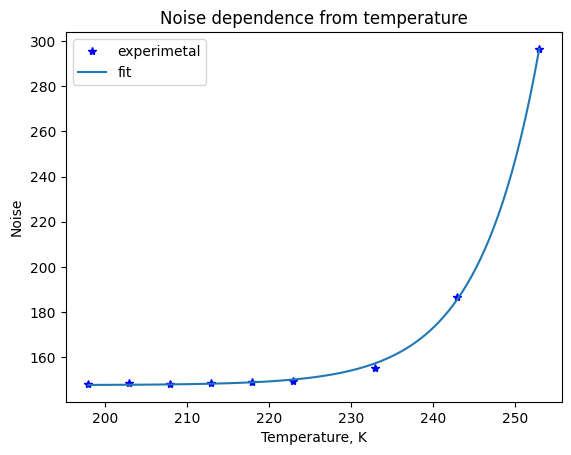

In [87]:
from scipy.optimize import curve_fit
'''
def exp(x, a, k):
    return a*np.exp(k * x)
'''

def exp(t, a, b, tau):
    return a + b*np.exp(t/tau)


t_k = np.array(temperatures) + 273

plt.plot(t_k, averages, 'b*', label='experimetal')

x_ticks = np.linspace(t_k[0], t_k[-1], 100)

p = [145, 1e-10, 10]
#p = [145, 1e-10, 10]
k_exp = curve_fit(exp, t_k, averages, p0=p)[0]
#m_lin = curve_fit(lin, x, np.log(y))[0]
y_appr = exp(x_ticks, *k_exp)


#param = np.polyfit(temperatures, averages, 2) # returns an array of coefficients of a polynomial of degree 2
plt.plot(x_ticks, y_appr, label='fit')

plt.legend()
plt.title("Noise dependence from temperature")
plt.xlabel("Temperature, K")
plt.ylabel("Noise")
plt.show()

What are the fitting parameters?

In [88]:
print(k_exp)

[1.47632425e+02 1.43173696e-13 7.31673808e+00]


#### Problem:

Compare prediction of different models for room temperature 300K.